# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [110]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [111]:
#Initial Trial Data is Stored on 17Jan23

data_folder = "SNR_100_BIC_filter_25May23"
analysis_file = "Post_Normalized_25May23"

# Signal Functions

In [112]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

def G_MB(t, alpha, beta, tau_1, tau_2, offSet):
    function = alpha*(beta*np.exp(-t/tau_1) + (1-beta)*np.exp(-t/tau_2)) + offSet
    return function

# Define Parameters

In [113]:
### Loading All Data Hyperparameters

with open(f'Intermediate_ExpResults/{data_folder}/{analysis_file}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    series_tag = dict['HyperParams_exp']
    gs_series_tag = dict['HyperParams_gs']
    n_iter_input = dict['iter_subset']
    post_normalize_data = dict['post_normalized']
    gs_BIC_choices = dict['gs_BIC_region']
    gs_nonreg_estimates = dict['gs_nonreg_est']
    gs_data = dict['gs_data']
    exp_BIC_region = dict['exp_BIC_region']
    nonreg_estimates = dict['exp_nonreg_est']
    GCV_estimates = dict['exp_GCV_est']
    GCV_curves = dict['exp_GCV_curves']
    GCV_lambdas = dict['exp_GCV_lam']
    all_data = dict['exp_data']
    n_hori = dict['n_horizontal']
    n_vert = dict['n_verticle']
    masked_region = dict['masked_region']
    SNR_goal = dict['SNR_goal']
    SNR_array = dict['SNR_array']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    model_oi = dict['model']
    gs_SNR_array = dict['gs_SNR'] 
    handle.close()


n_iter_input_check, n_vert_check, n_hori_check, n_parameters = nonreg_estimates.shape
assert(n_iter_input_check == n_iter_input)
assert(n_vert_check == n_vert)
assert(n_hori_check == n_hori)

c1_ref = gs_nonreg_estimates[:,:,0]

n_elements = len(tdata)

n_lambdas = len(lambdas)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [114]:
print(gs_SNR_array)

[137.50823343413293]


# Define General Functions

### Small Helper Functions

In [115]:
def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def calc_improvement(old, new):
    return (old - new)/old

def calc_improvement_ref(old, new, ref):
    return (old - new)/ref**2

def calc_improvement_diff(old, new):
    return (old - new)

#Mean Square Difference
def calculate_MSD(real, est):
    assert(real.shape == est.shape)
    square_diff = (real - est)**2
    square_diff_zero = square_diff[real!=0] #nonzero locations = we only care about the MSD around these points
    NLLS_brain_bias = np.sum(square_diff)/square_diff[square_diff>0].size #This is a better way to find 
    mean_square_diff = np.mean(square_diff_zero)
    # assert(math.isclose(NLLS_brain_bias,mean_square_diff)) #This breaks - the difference is about 5-10%
    return NLLS_brain_bias

#Mean Square Difference
def calculate_MSD_norm(real, est):
    assert(real.shape == est.shape)
    good_index = (real[:,:,0]!=0) * (est[:,:,0]!=0)
    
    square_diff = (real - est)**2
    real_divider = real.copy()
    real_divider[~good_index] = 1 #To ensure we don't divide by 0
    norm_sqD = square_diff/real_divider**2 #Divides all square differences by the square felucital value for that pixel
    sum_normSqD = np.sum(norm_sqD,axis=2) #Sum up all normalized values across the number of parameters

    MSD_metric = sum_normSqD**(1/2) #Square root value
    avg_metric = np.sum(MSD_metric)/MSD_metric[good_index].size #Average of the MSD metrics calculated

    return MSD_metric, avg_metric

def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori, 0]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori, 0]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1, 0]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1, 0]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Images

### Brain Outline

Text(0.5, 1.0, 'Brain Outline')

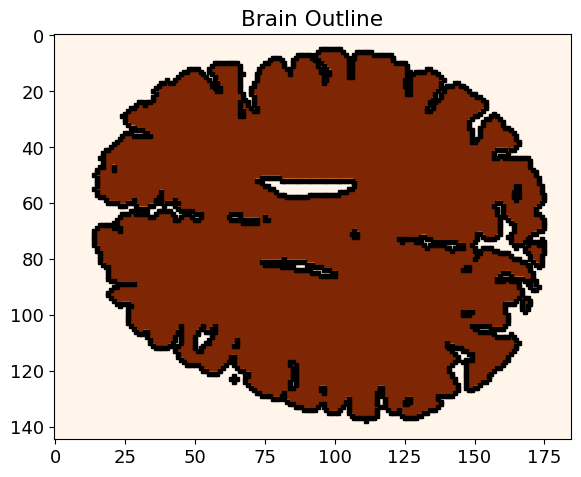

In [116]:
###########Brain Outline#################
#Use line 9 as a final line on any figure where you want to show the outline of the brain

brain_outline = get_brain_outline(masked_region)
outline_indices = np.where(brain_outline == 1)

fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)
ax.imshow(masked_region[:,:,0], cmap = 'Oranges')
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax.set_title('Brain Outline')


### BIC Regions

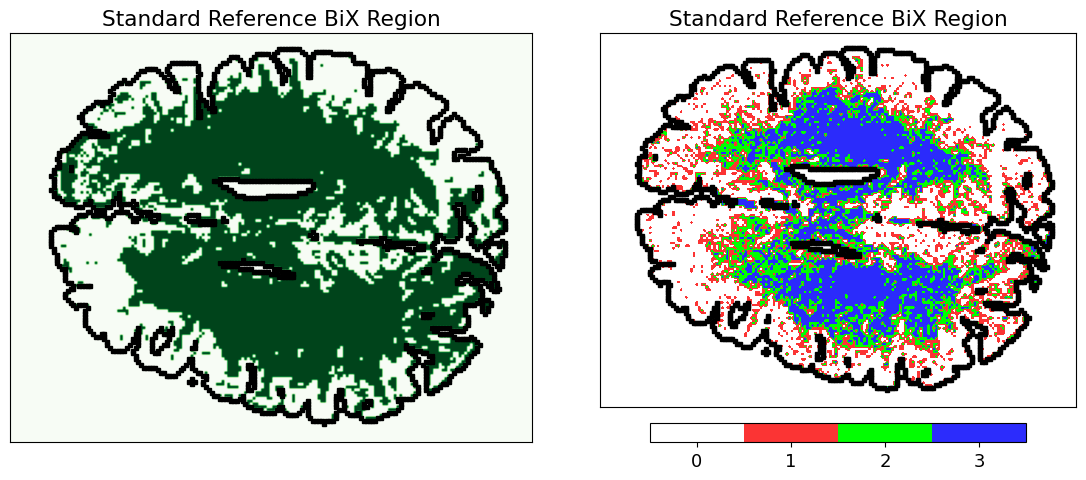

In [123]:
fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

ax[0].imshow(gs_BIC_choices, cmap = 'Greens')
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[0].set_title('Standard Reference BiX Region')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

gen_colors = [(1,1,1)] + _get_colors(n_iter_input)
BiX_freq_cmap = colors.ListedColormap(gen_colors)
BIC = ax[1].imshow(np.sum(exp_BIC_region, axis = 0), cmap = BiX_freq_cmap, vmin = -0.5, vmax = n_iter_input+0.5)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[1].set_title('Standard Reference BiX Region')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
fig.colorbar(BIC, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')

##### Parameter Maps

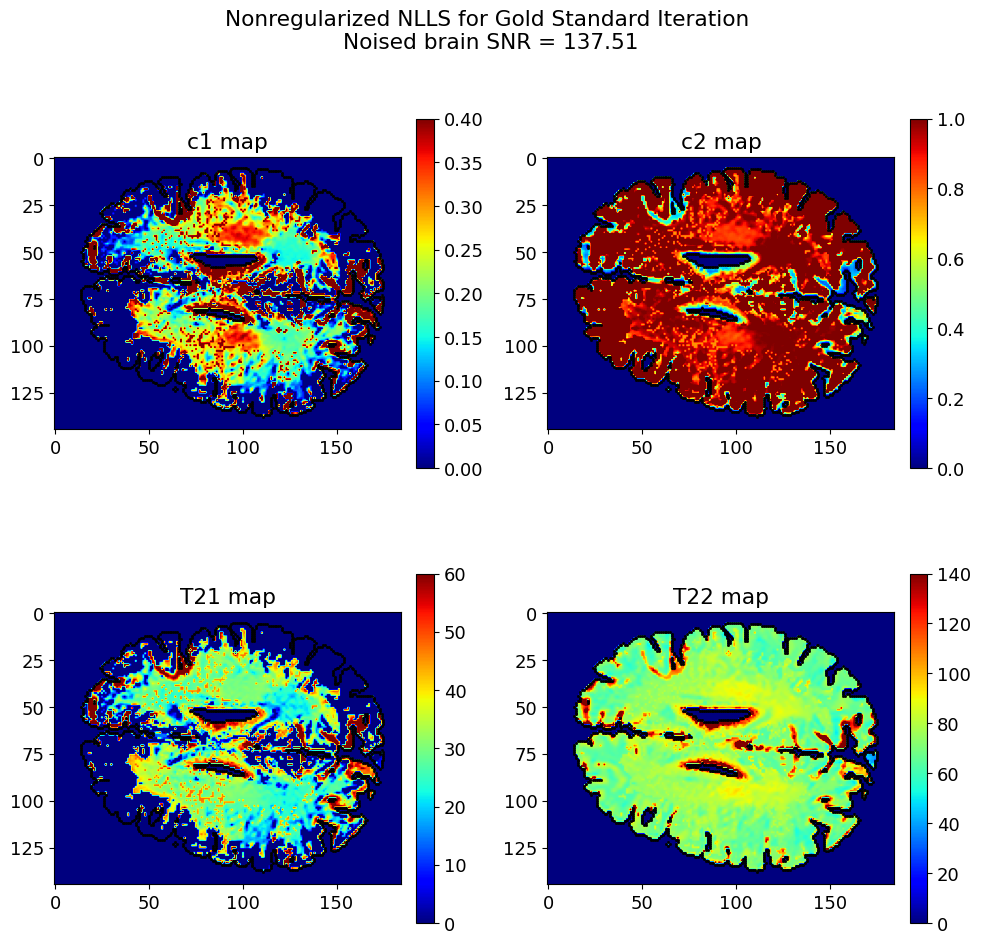

In [122]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'Nonregularized NLLS for Gold Standard Iteration \nNoised brain SNR = {np.round(gs_SNR_array[0],2)}' )
# if gs_MB_model:
#     imc1 = ax[0,0].imshow(gs_nonreg_estimates[:,:,1], cmap = 'jet', vmin=0, vmax = 0.4)
#     ax[0,0].set_title('c1 map')
#     ax[0,1].axis('off')
# else:
imc1 = ax[0,0].imshow(gs_nonreg_estimates[:,:,0], cmap = 'jet', vmin=0, vmax = 0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(gs_nonreg_estimates[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)

imT21 = ax[1,0].imshow(gs_nonreg_estimates[:,:,2], cmap = 'jet', vmin=0, vmax = 60)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(gs_nonreg_estimates[:,:,3], cmap = 'jet', vmin=0, vmax = 140)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)

fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

In [51]:
# matlab_reference = scipy.io.loadmat('MB_References/BLSA_1742_04_MCIAD_m41/m41_dataStruct_slice5.mat')
# slice_ds = matlab_reference['slice']
# slice_T22 = slice_ds['T2l'][0,0]
# slice_T21 = slice_ds['T2s'][0,0]
# slice_c1 = slice_ds['MWF'][0,0]

# if subsection:
#     I_raw_x = slice_c1.shape[0]//4
#     I_raw_y = slice_c1.shape[1]//4
#     slice_c1 = slice_c1[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y]
#     slice_T21 = slice_T21[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y]
#     slice_T22 = slice_T22[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y]

In [52]:
# fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
# fig.suptitle(f'MB Parameter Estimation Results' )
# ax[0,1].axis('off')

# imc2 = ax[0,0].imshow(slice_c1, cmap = 'jet', vmin=0, vmax=0.4)
# ax[0,0].set_title('c1 map')

# imT21 = ax[1,0].imshow(slice_T21, cmap = 'jet', vmin=0, vmax = 60)
# ax[1,0].set_title('T21 map')

# imT22 = ax[1,1].imshow(slice_T22, cmap = 'jet', vmin=0, vmax = 140)
# ax[1,1].set_title('T22 map')

# # fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
# fig.colorbar(imc2, ax=ax[0,0], fraction=0.046, pad=0.04)
# fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
# fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
# plt.show()

In [53]:
# fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
# fig.suptitle("Absolute Difference of GS and MB Parameter Estimates")
# ax[0,1].axis('off')

# # if gs_MB_model:
# #     imc2 = ax[0,0].imshow(np.abs(slice_c1 - gs_nonreg_estimates[:,:,1]), cmap = 'jet', vmin=0)
# # else:
# imc2 = ax[0,0].imshow(np.abs(slice_c1 - gs_nonreg_estimates[:,:,0])*(gs_nonreg_estimates[:,:,0]!=0), cmap = 'jet', vmin=0)
# ax[0,0].set_title('c1 map')

# imT21 = ax[1,0].imshow(np.abs(slice_T21 - gs_nonreg_estimates[:,:,2])*(gs_nonreg_estimates[:,:,1]!=0), cmap = 'jet', vmin=0)
# ax[1,0].set_title('T21 map')

# imT22 = ax[1,1].imshow(np.abs(slice_T22 - gs_nonreg_estimates[:,:,3])*(gs_nonreg_estimates[:,:,1]!=0), cmap = 'jet', vmin=0)
# ax[1,1].set_title('T22 map')

# # fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
# fig.colorbar(imc2, ax=ax[0,0], fraction=0.046, pad=0.04)
# fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
# fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
# plt.show()

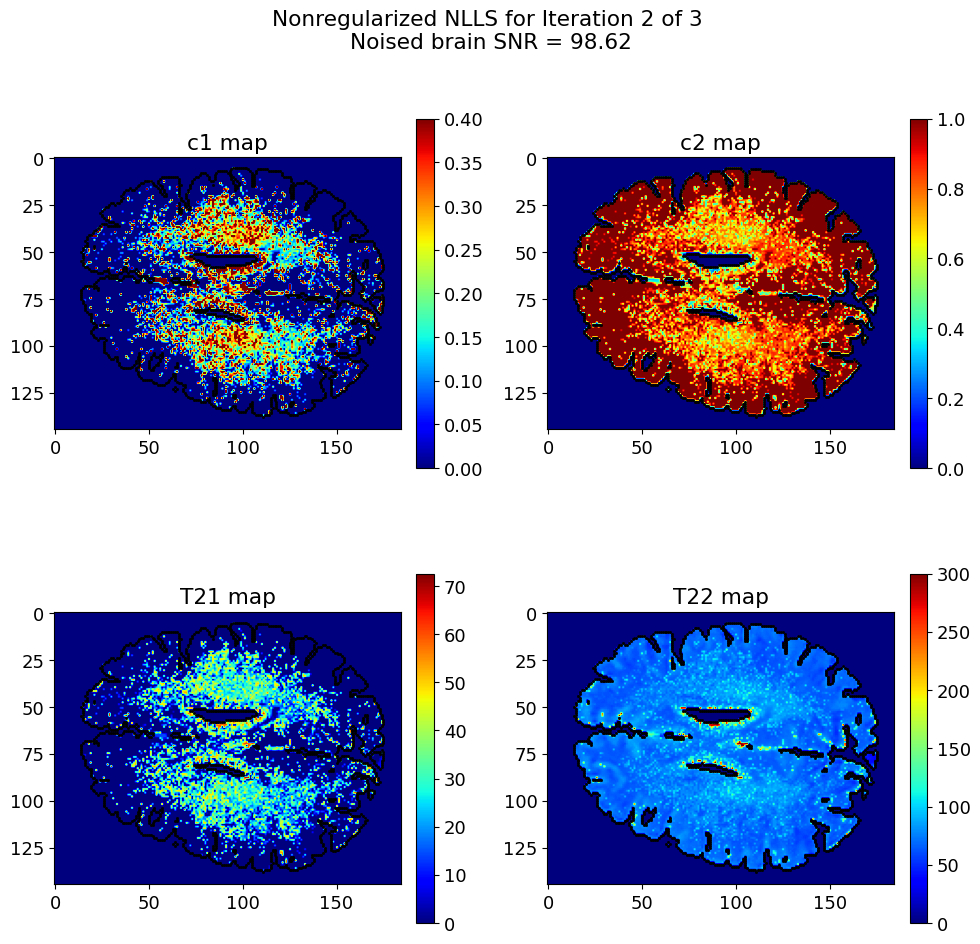

In [120]:
iter_oi = 1
assert(iter_oi < n_iter_input)

fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'Nonregularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax[0,0].imshow(nonreg_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(nonreg_estimates[iter_oi,:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT21 = ax[1,0].imshow(nonreg_estimates[iter_oi,:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(nonreg_estimates[iter_oi,:,:,3], cmap = 'jet', vmin=0)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

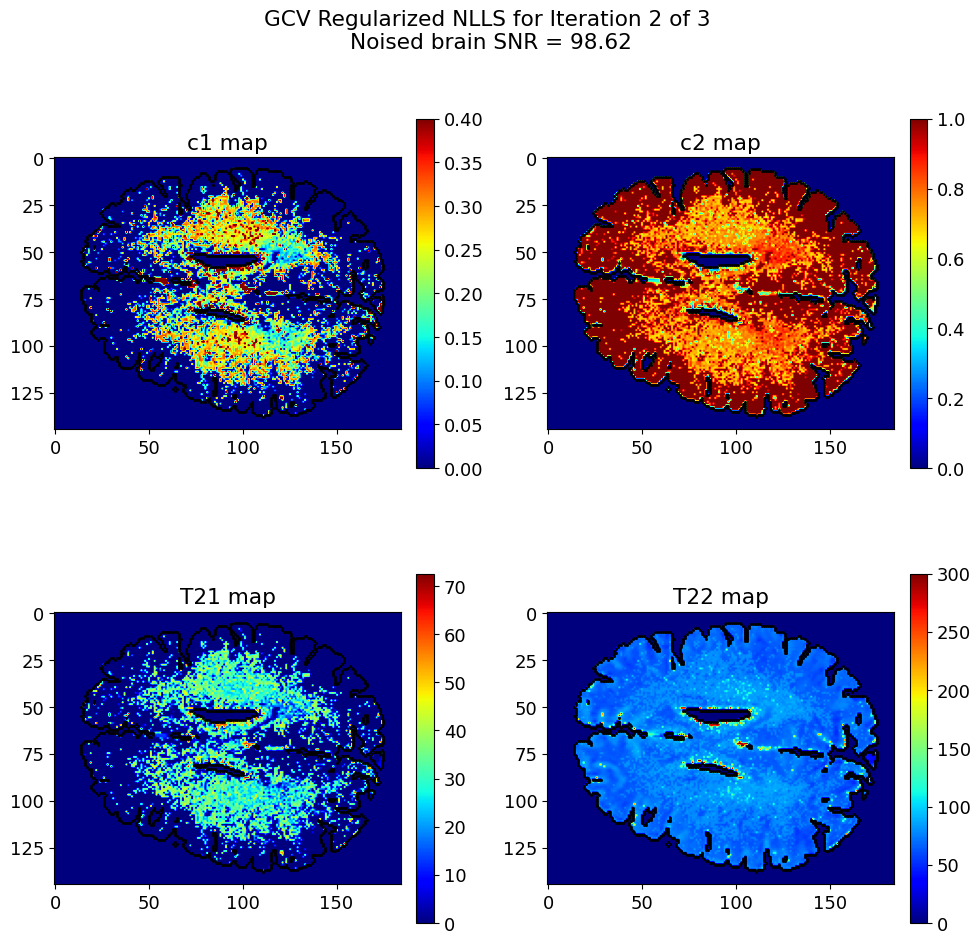

In [121]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax[0,0].imshow(GCV_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(GCV_estimates[iter_oi,:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT21 = ax[1,0].imshow(GCV_estimates[iter_oi,:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(GCV_estimates[iter_oi,:,:,3], cmap = 'jet', vmin=0)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

##### Regularization Curve Analysis

/tmp/ipykernel_2253113/155759047.py:10: RuntimeWarning: divide by zero encountered in log10
  imc2 = ax[1].imshow(np.log10(GCV_lambdas[iter_oi,:,:]), cmap = 'jet')


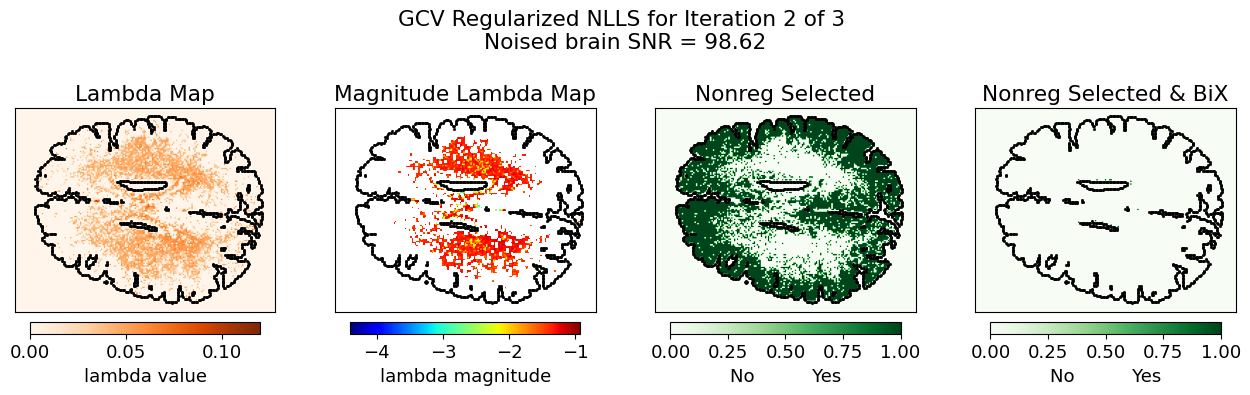

In [138]:
fig, ax = plt.subplots(1, 4, figsize=(13,4), tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )

imc1 = ax[0].imshow(GCV_lambdas[iter_oi,:,:], cmap = 'Oranges')
ax[0].set_title('Lambda Map')
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04, label = 'lambda value', location = 'bottom')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[1].imshow(np.log10(GCV_lambdas[iter_oi,:,:]), cmap = 'jet')
ax[1].set_title('Magnitude Lambda Map')
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04, label = 'lambda magnitude', location = 'bottom')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc3 = ax[2].imshow((GCV_lambdas[iter_oi,:,:]==0)*masked_region[:,:,0], cmap = 'Greens')
ax[2].set_title('Nonreg Selected')
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04, label = 'No          Yes', location = 'bottom')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc4 = ax[3].imshow((GCV_lambdas[iter_oi,:,:]==0)*masked_region[:,:,0]*exp_BIC_region[iter_oi,:,:], cmap = 'Greens')
ax[3].set_title('Nonreg Selected & BiX')
fig.colorbar(imc4, ax=ax[3], fraction=0.046, pad=0.04, label = 'No          Yes', location = 'bottom')
ax[3].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[3].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

plt.show()

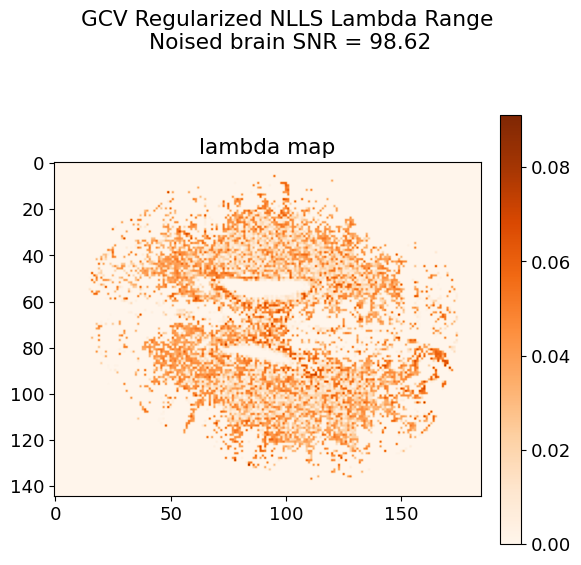

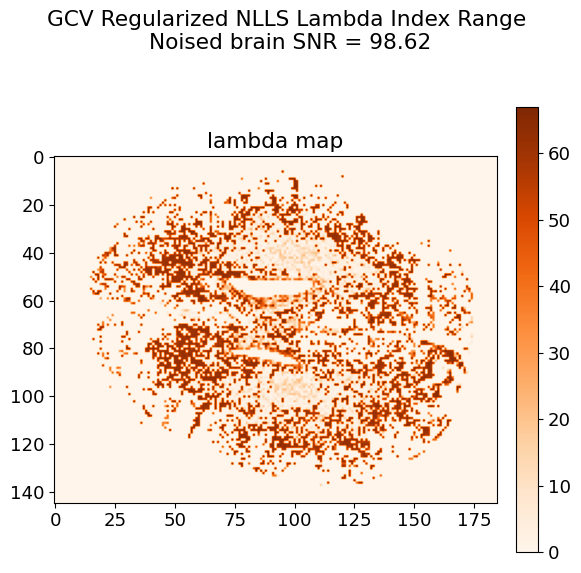

In [57]:
fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS Lambda Range \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax.imshow(np.abs(np.max(GCV_lambdas[:,:,:], axis = 0) - np.min(GCV_lambdas[:,:,:], axis = 0)), cmap = 'Oranges')
ax.set_title('lambda map')

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

max_lambda_ind = np.zeros((GCV_lambdas.shape[1:3]))
min_lambda_ind = np.zeros((GCV_lambdas.shape[1:3]))
for i in range(GCV_lambdas.shape[1]):
    for j in range(GCV_lambdas.shape[2]):
        max_lambda_ind[i,j] = np.where(lambdas == np.max(GCV_lambdas[:,i,j]))[0][0]
        min_lambda_ind[i,j] = np.where(lambdas == np.min(GCV_lambdas[:,i,j]))[0][0]

index_differences = np.abs(max_lambda_ind - min_lambda_ind)

fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS Lambda Index Range \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax.imshow(index_differences, cmap = 'Oranges')
ax.set_title('lambda map')

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

In [58]:
# rep_pointX = pixels[1,1]
# rep_pointY = pixels[1,0]

# high_reg_val = -55

# print(f'Parameter Estimates for max lambda = {all_reg_estimates[iter_oi, rep_pointX, rep_pointY, -1,:]}')

# fig, ax = plt.subplots(2,2,figsize=(7,9),tight_layout=True)
# fig.suptitle(f'GCV Regularized NLLS Curve for Iteration {iter_oi+1} of {n_iterations} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
# imc1 = ax[0,0].imshow(all_nonreg_estimates[iter_oi,:,:,0]>0, cmap = 'Oranges', vmin = 0, vmax = 1.5)
# imc1 = ax[0,0].plot(rep_pointX, rep_pointY, color = 'k', marker = 'o')
# ax[0,0].set_title('Point of Focus')

# ax[0,1].loglog(lambdas, all_GCV_curves[iter_oi, rep_pointX, rep_pointY,:], color = 'k')
# ax[0,1].axvline(x = all_GCV_lambdas[iter_oi, rep_pointX, rep_pointY], color = 'r', label = r'minimum $\lambda$')
# # ax[0,1].plot(lambdas[high_reg_val], all_GCV_curves[iter_oi, rep_pointX, rep_pointY,high_reg_val], marker = 'o', color = 'g', label = "Ex. reg curve" , ls = '')
# ax[0,1].set_title('GCV Curve')
# ax[0,1].set_ylabel('GCV Value')
# ax[0,1].set_xlabel('Lambda Value')
# ax[0,1].legend()

# ax[1,1].loglog(lambdas, all_RSS[iter_oi, rep_pointX, rep_pointY,:], color = 'k')
# ax[1,1].axvline(x = all_GCV_lambdas[iter_oi, rep_pointX, rep_pointY], color = 'r', label = r'minimum $\lambda$')
# # ax[1,1].plot(lambdas[high_reg_val], all_RSS[iter_oi, rep_pointX, rep_pointY, high_reg_val], marker = 'o', color = 'g', label = "Ex. reg curve", ls = '')
# ax[1,1].set_title('RSS Curve')
# ax[1,1].set_ylabel('RSS')
# ax[1,1].set_xlabel('Lambda Value')
# ax[1,1].legend()


# ax[1,0].plot(tdata, all_data[iter_oi, rep_pointX, rep_pointY, :], color = 'k', label = "data")
# ax[1,0].plot(tdata, G_off(tdata, *all_nonreg_estimates[iter_oi, rep_pointX, rep_pointY, :]), label = "nonreg", alpha = 0.4, ls = ":", color = 'b')
# ax[1,0].plot(tdata, G_off(tdata, *all_GCV_estimates[iter_oi, rep_pointX, rep_pointY, :]), label = "GCV", alpha = 0.4, ls = "--", color = 'r')
# # ax[1,0].plot(tdata, G(tdata, *all_reg_estimates[iter_oi, rep_pointX, rep_pointY, high_reg_val, :]), label = f"Ex. reg " + r'$\lambda$' + f" = {lambdas[high_reg_val]:.2f}", color = 'g')
# ax[1,0].set_xlabel('Time (ms)')
# ax[1,0].set_ylabel('Signal')
# ax[1,0].set_title("Fit Curves")
# ax[1,0].legend()

# plt.show()

In [59]:
# pixels = np.array([[52,38],[40,62],[40,37],[42,18]])
# test_pointsX = pixels[:,1]
# test_pointsY = pixels[:,0]

# for i_point in range(np.size(test_pointsX)):

#     point_X = test_pointsX[i_point]
#     point_Y = test_pointsY[i_point]

#     plt.rc('font', size  = 11)
#     fig, ax = plt.subplots(2,2, figsize=(8,6), tight_layout=True)
#     fig.suptitle(f'Regularized Parameter Value for Point ({point_Y}, {point_X})\nIteration {iter_oi+1} of {n_iterations} :: Noised brain SNR = {np.round(SNR_array[iter_oi],2)}')
#     for i in range(4):

#         ax[i//2, i%2].semilogx(lambdas, all_reg_estimates[iter_oi, point_Y, point_X, :, i], label = f"{param_name_list[i]} curve", alpha = 0.7, color = "k")
#         ax[i//2, i%2].axvline(x = all_GCV_lambdas[iter_oi, point_Y, point_X], label = r'Best $\lambda$', color = 'r')
#         ax[i//2, i%2].axhline(y = gs_nonreg_estimates[point_Y, point_X,i], label = r'Gold Standard Value', color = 'b')
#         ax[i//2, i%2].set_xlabel('Regularization Lambda')
#         ax[i//2, i%2].set_ylabel('Parameter Value')
#         ax[i//2, i%2].set_title(param_name_list[i] + ' Value vs. Lambda')
#         ax[i//2, i%2].legend()
#     plt.show()

# fig, ax = plt.subplots(1,1,figsize=(5,5),tight_layout=True)
# fig.suptitle(f'Points Analyzed for Iteration {iter_oi+1} of {n_iterations} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
# ax.imshow(all_nonreg_estimates[iter_oi,:,:,0]>0, cmap = 'Oranges', vmin = 0, vmax = 1.5)
# ax.plot(test_pointsX, test_pointsY, color = 'k', marker = 'o', ls = '')
# ax.set_title('Points of Focus')

##### MWF Comparison Graphs

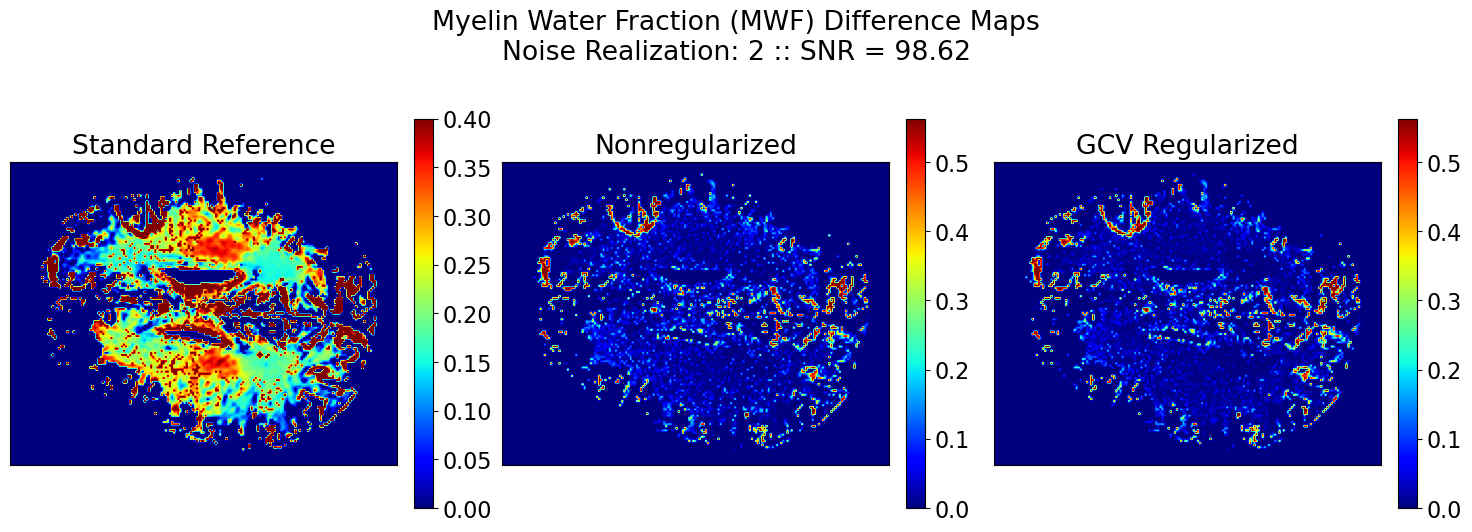

In [60]:
NLLS_diff = (nonreg_estimates[iter_oi,:,:,0] - c1_ref)**2
GCV_diff = (GCV_estimates[iter_oi,:,:,0] - c1_ref)**2

NLLS_MSD = calculate_MSD(c1_ref, nonreg_estimates[iter_oi,:,:,0])
GCV_MSD = calculate_MSD(c1_ref, GCV_estimates[iter_oi,:,:,0])

NLLS_MSD_map, NLLS_MSD_norm = calculate_MSD_norm(gs_nonreg_estimates, nonreg_estimates[iter_oi,:,:,:])
GCV_MSD_map, GCV_MSD_norm = calculate_MSD_norm(gs_nonreg_estimates, GCV_estimates[iter_oi,:,:,:])

fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 16)
fig.suptitle('Myelin Water Fraction (MWF) Difference Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
imref = ax[0].imshow(c1_ref, cmap = 'jet', vmin = 0, vmax = 0.4)
ax[0].set_title('Standard Reference')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

imNLLS = ax[1].imshow(NLLS_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[1].set_title('Nonregularized')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_MSD,5), color='w')
# ax[1].text(10, 20, 'All Param Mean Square Difference = %s'%round(NLLS_MSD_total,5), color='w')
# ax[1].text(10, 20, 'All Norm Mean Square Difference = %s'%round(NLLS_MSD_norm,5), color='w')

imGCV = ax[2].imshow(GCV_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[2].set_title('GCV Regularized')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_MSD,5), color='w')
# ax[2].text(10, 20, 'All Param Mean Square Difference = %s'%round(GCV_MSD_total,5), color='w')
# ax[2].text(10, 20, 'All Norm Mean Square Difference = %s'%round(GCV_MSD_norm,5), color='w')

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
plt.show()

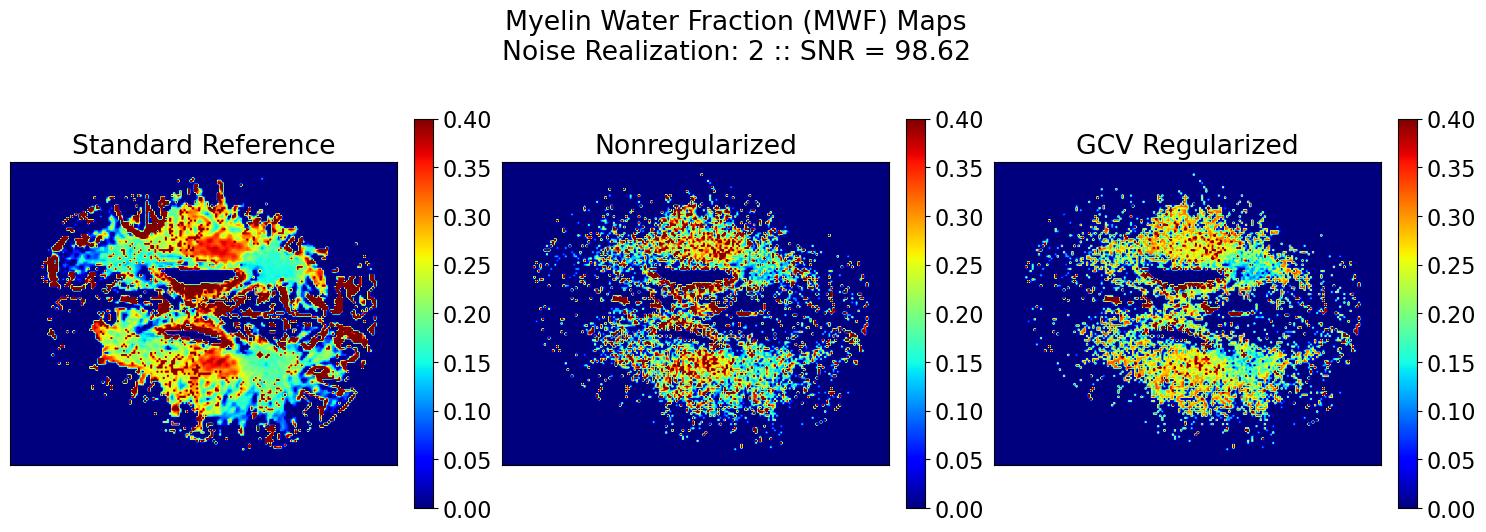

In [61]:
fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 16)
fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
imref = ax[0].imshow(c1_ref, cmap = 'jet', vmin = 0, vmax = 0.4)
ax[0].set_title('Standard Reference')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

imNLLS = ax[1].imshow(nonreg_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[1].set_title('Nonregularized')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

imGCV = ax[2].imshow(GCV_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[2].set_title('GCV Regularized')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
plt.show()

##### MSE Composistion Maps

In [62]:
params_oi = [0]        #We are primarily interested in c1 which makes the 0th parameter the interesting one

varMap_NLLS = np.var(nonreg_estimates, axis = 0)
varMap_GCV = np.var(GCV_estimates, axis = 0)

sqbMap_NLLS = (np.mean(nonreg_estimates, axis = 0) - gs_nonreg_estimates)**2
sqbMap_GCV = (np.mean(GCV_estimates, axis = 0) - gs_nonreg_estimates)**2

MSEMap_NLLS = varMap_NLLS + sqbMap_NLLS
MSEMap_GCV = varMap_GCV + sqbMap_GCV

/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: divide by zero encountered in divide
  return (old - new)/old
/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: invalid value encountered in divide
  return (old - new)/old


Post Normalized: True


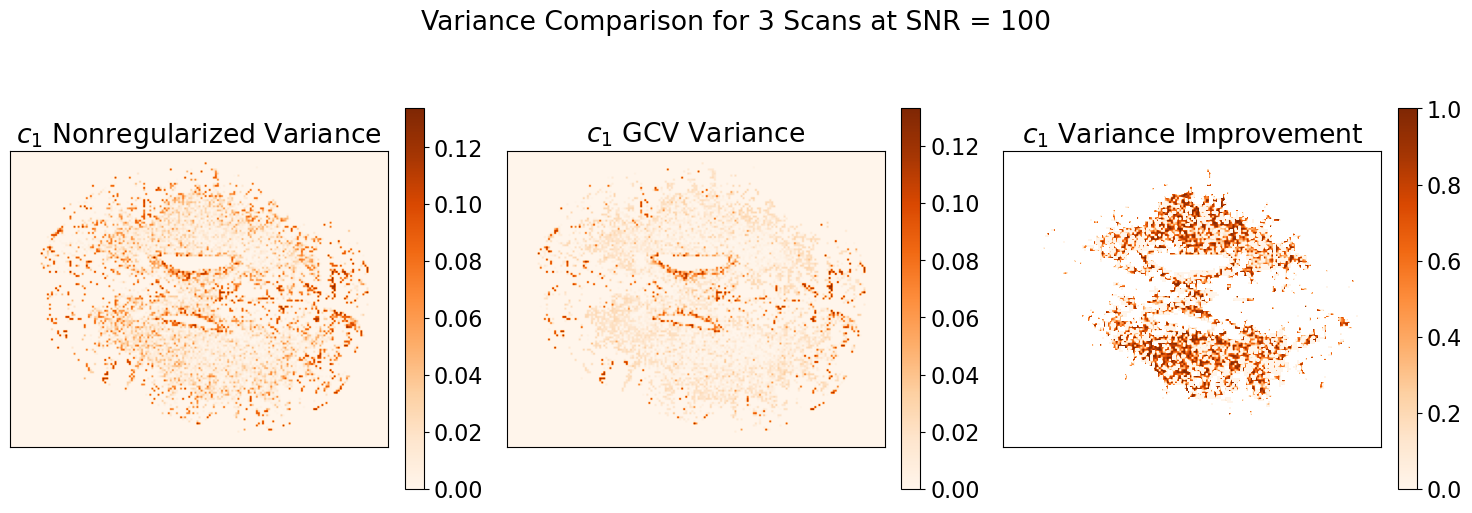

In [63]:
#Variance Improvment Under Regularization Cases

var_improvement = calc_improvement(varMap_NLLS, varMap_GCV)
sqBias_improvement = calc_improvement(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement = calc_improvement(MSEMap_NLLS, MSEMap_GCV)

or_map = plt.get_cmap('Oranges')
# or_map.set_extremes(under = 'blue')
extend_opt = "neither" #min, max, both, neither

print(f'Post Normalized: {post_normalize_data}')
for param_oi in params_oi:

    fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
    plt.rc('font', size  = 16)
    fig.suptitle(f'Variance Comparison for {n_iter_input} Scans at SNR = {SNR_goal}' )

    ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[0].imshow(varMap_NLLS[:,:,param_oi], cmap = or_map, vmin=0)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[0].set_title(param_name_list[param_oi] + ' Nonregularized Variance' )
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[1].imshow(varMap_GCV[:,:,param_oi], cmap = or_map, vmin=0)
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[1].set_title(param_name_list[param_oi] + ' GCV Variance' )
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[2].imshow(var_improvement[:,:,param_oi], cmap = or_map, vmin=0, vmax=1)
    fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[2].set_title(param_name_list[param_oi] + ' Variance Improvement' )
    ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    plt.show()

/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: divide by zero encountered in divide
  return (old - new)/old
/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: invalid value encountered in divide
  return (old - new)/old


Post Normalized: True


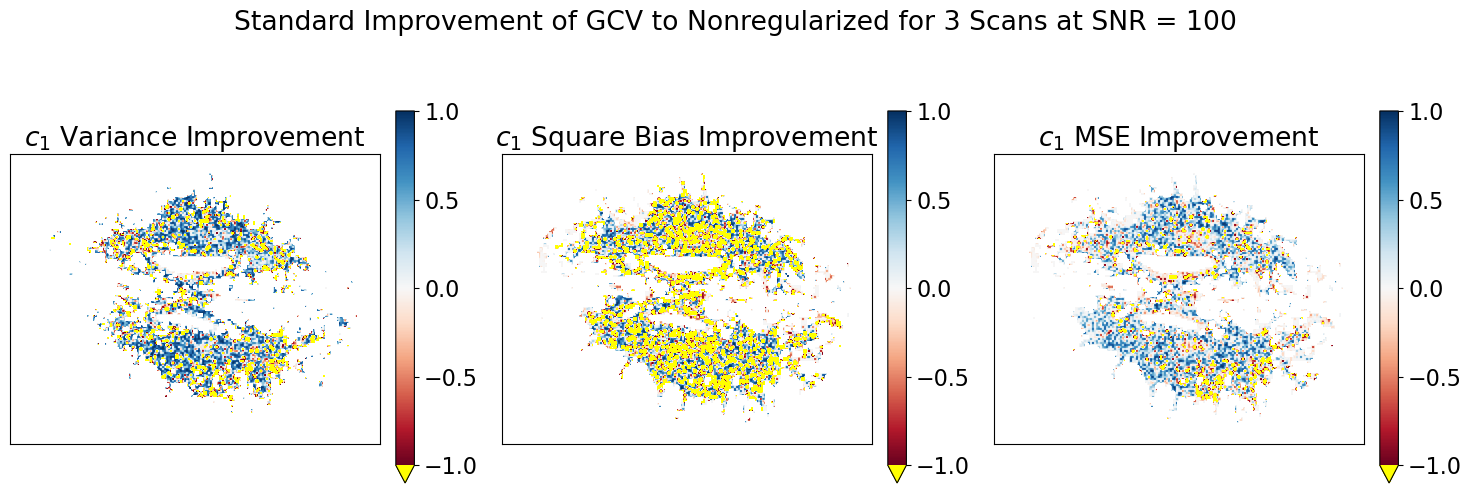

In [64]:
#MSE Component Improvement Figures

var_improvement = calc_improvement(varMap_NLLS, varMap_GCV)
sqBias_improvement = calc_improvement(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement = calc_improvement(MSEMap_NLLS, MSEMap_GCV)

or_map = plt.get_cmap('RdBu')
or_map.set_extremes(under = 'yellow')
extend_opt = "min"

print(f'Post Normalized: {post_normalize_data}')
for param_oi in params_oi:

    fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
    plt.rc('font', size  = 16)
    fig.suptitle(f'Standard Improvement of GCV to Nonregularized for {n_iter_input} Scans at SNR = {SNR_goal}' )

    ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[0].imshow(var_improvement[:,:,param_oi], cmap = or_map, vmin=-1, vmax=1)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[0].set_title(param_name_list[param_oi] + ' Variance Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[1].imshow(sqBias_improvement[:,:,param_oi], cmap = or_map, vmin=-1, vmax=1)
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[1].set_title(param_name_list[param_oi] + ' Square Bias Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[2].imshow(MSE_improvement[:,:,param_oi], cmap = or_map, vmin=-1, vmax=1)
    fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[2].set_title(param_name_list[param_oi] + ' MSE Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    plt.show()

/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: divide by zero encountered in divide
  return (old - new)/old
/tmp/ipykernel_2253113/1753810309.py:17: RuntimeWarning: invalid value encountered in divide
  return (old - new)/old


Post Normalized: True


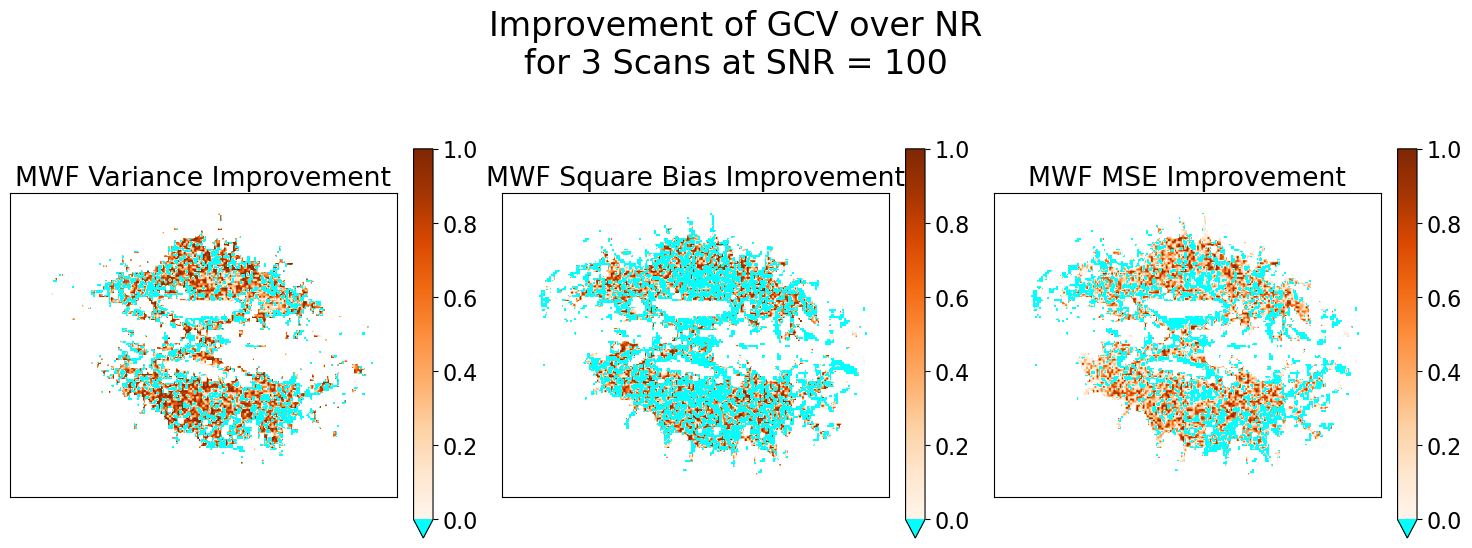

In [65]:
#MSE Component Improvement Figures

var_improvement = calc_improvement(varMap_NLLS, varMap_GCV)
sqBias_improvement = calc_improvement(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement = calc_improvement(MSEMap_NLLS, MSEMap_GCV)

or_map = plt.get_cmap('Oranges')
or_map.set_extremes(under = 'cyan')
extend_opt = "min"


print(f'Post Normalized: {post_normalize_data}')

fig, ax = plt.subplots(1,3,figsize=(15,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Improvement of GCV over NR\nfor {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)
ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[0].imshow(var_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
ax[0].set_title('MWF Variance Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[1].imshow(sqBias_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
ax[1].set_title('MWF Square Bias Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[2].imshow(MSE_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
ax[2].set_title('MWF MSE Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

/tmp/ipykernel_2253113/1753810309.py:20: RuntimeWarning: divide by zero encountered in divide
  return (old - new)/ref**2
/tmp/ipykernel_2253113/1753810309.py:20: RuntimeWarning: invalid value encountered in divide
  return (old - new)/ref**2


Post Normalized: True


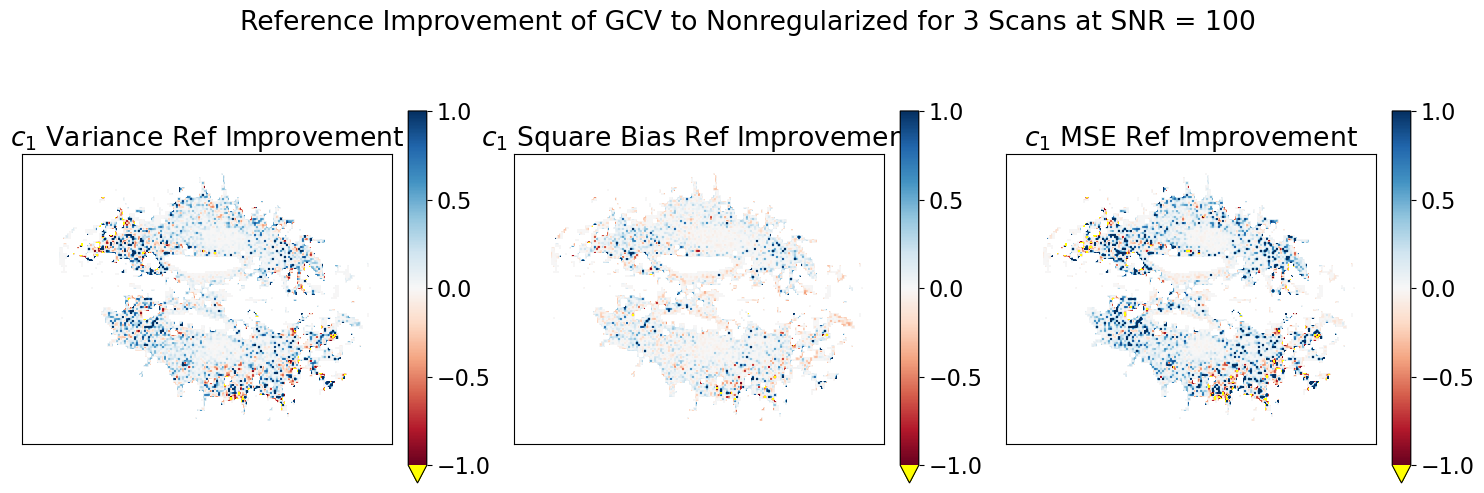

In [66]:
#MSE Component Improvement Ref Figures

var_improvement_ref = calc_improvement_ref(varMap_NLLS, varMap_GCV, gs_nonreg_estimates)
sqBias_improvement_ref = calc_improvement_ref(sqbMap_NLLS, sqbMap_GCV, gs_nonreg_estimates)
MSE_improvement_ref = calc_improvement_ref(MSEMap_NLLS, MSEMap_GCV, gs_nonreg_estimates)

or_map = plt.get_cmap('RdBu')
or_map.set_extremes(under = 'yellow')
extend_opt = "min"

print(f'Post Normalized: {post_normalize_data}')
for param_oi in params_oi:

    fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
    plt.rc('font', size  = 16)
    fig.suptitle(f'Reference Improvement of GCV to Nonregularized for {n_iter_input} Scans at SNR = {SNR_goal}' )

    ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[0].imshow(var_improvement_ref[:,:,param_oi], cmap = or_map, vmin=-1, vmax = 1)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[0].set_title(param_name_list[param_oi] + ' Variance Ref Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[1].imshow(sqBias_improvement_ref[:,:,param_oi], cmap = or_map, vmin=-1, vmax = 1)
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[1].set_title(param_name_list[param_oi] + ' Square Bias Ref Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[2].imshow(MSE_improvement_ref[:,:,param_oi], cmap = or_map, vmin=-1, vmax = 1)
    fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[2].set_title(param_name_list[param_oi] + ' MSE Ref Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    plt.show()

Post Normalized: True


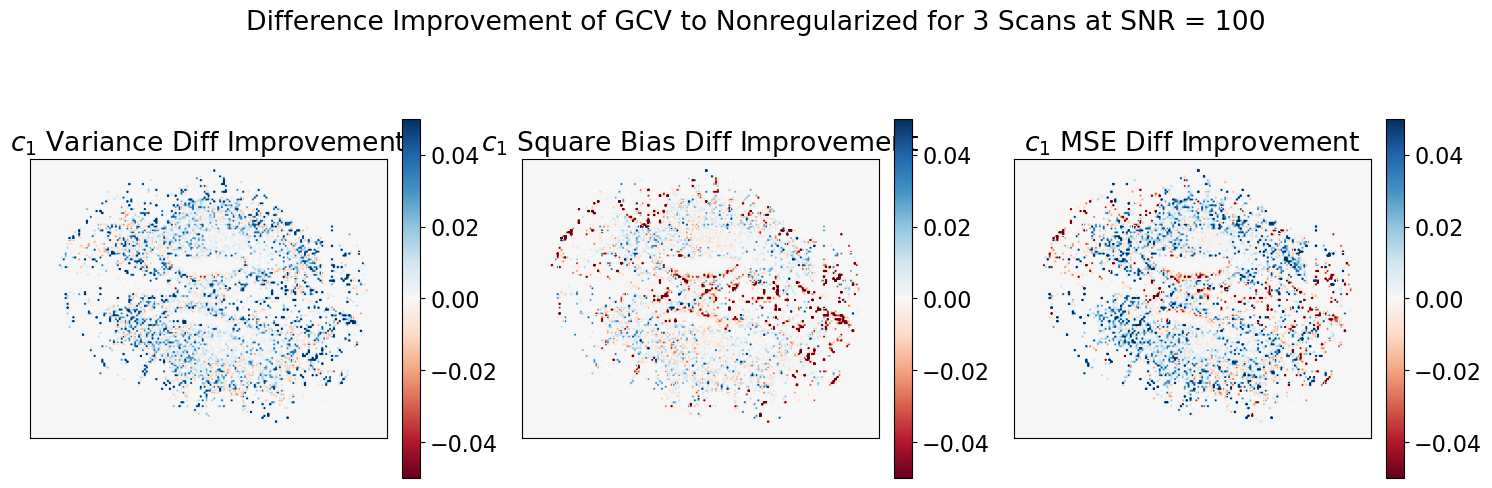

In [67]:
#MSE Component Improvement Diff Figures

var_improvement_diff = calc_improvement_diff(varMap_NLLS, varMap_GCV)
sqBias_improvement_diff = calc_improvement_diff(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement_diff = calc_improvement_diff(MSEMap_NLLS, MSEMap_GCV)
RMSE_improvement_diff = calc_improvement_diff(MSEMap_NLLS**(1/2), MSEMap_GCV**(1/2))

or_map = plt.get_cmap('RdBu')
# or_map.set_extremes(under = 'yellow')
# extend_opt = "min"


print(f'Post Normalized: {post_normalize_data}')
for param_oi in params_oi:

    negMag = np.abs(np.min(MSE_improvement_diff[:,:,param_oi]))
    posMag = np.abs(np.max(MSE_improvement_diff[:,:,param_oi]))
    MSERange = np.max(np.array([negMag, posMag]))
    MSERange = 0.05
          
    fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
    plt.rc('font', size  = 16)
    fig.suptitle(f'Difference Improvement of GCV to Nonregularized for {n_iter_input} Scans at SNR = {SNR_goal}' )

    
    ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[0].imshow(var_improvement_diff[:,:,param_oi], cmap = or_map, vmin=-MSERange, vmax = MSERange)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04)
    ax[0].set_title(param_name_list[param_oi] + ' Variance Diff Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[1].imshow(sqBias_improvement_diff[:,:,param_oi], cmap = or_map, vmin=-MSERange, vmax = MSERange)
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04)
    ax[1].set_title(param_name_list[param_oi] + ' Square Bias Diff Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[2].imshow(MSE_improvement_diff[:,:,param_oi], cmap = or_map, vmin=-MSERange, vmax = MSERange)
    fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04)
    ax[2].set_title(param_name_list[param_oi] + ' MSE Diff Improvement' )#+ '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
    ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    plt.show()

Post Normalized: True


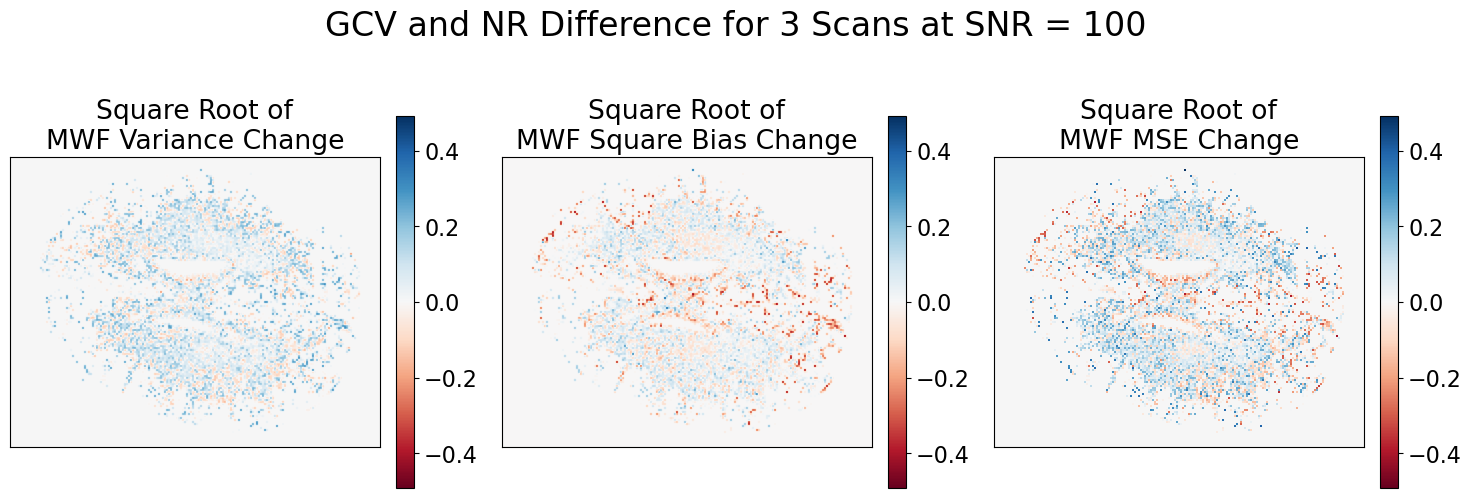

In [68]:
print(f'Post Normalized: {post_normalize_data}')

or_map = plt.get_cmap('RdBu')
or_map.set_bad(alpha=0)
my_Gmap = plt.get_cmap('gray')
# my_Gmap.set_bad(alpha=0)
# brain_outline[brain_outline > 0.1] = np.nan

imp_index = var_improvement_diff[:,:,0]>0
wor_index = var_improvement_diff[:,:,0]<0
imp_group = (var_improvement_diff[:,:,0]*imp_index)**(1/2)
wor_group = (var_improvement_diff[:,:,0]*-1*wor_index)**(1/2)
var_hold = np.zeros((var_improvement_diff[:,:,0].shape))
var_hold = var_hold + imp_group + wor_group*-1
# var_hold[var_hold == 0] = np.nan

imp_index = sqBias_improvement_diff[:,:,0]>0
wor_index = sqBias_improvement_diff[:,:,0]<0
imp_group = (sqBias_improvement_diff[:,:,0]*imp_index)**(1/2)
wor_group = (sqBias_improvement_diff[:,:,0]*-1*wor_index)**(1/2)
sqBias_hold = np.zeros((sqBias_improvement_diff[:,:,0].shape))
sqBias_hold = sqBias_hold + imp_group + wor_group*-1
# sqBias_hold[sqBias_hold == 0] = np.nan

imp_index = MSE_improvement_diff[:,:,0]>0
wor_index = MSE_improvement_diff[:,:,0]<0
imp_group = (MSE_improvement_diff[:,:,0]*imp_index)**(1/2)
wor_group = (MSE_improvement_diff[:,:,0]*-1*wor_index)**(1/2)
MSE_hold = np.zeros((MSE_improvement_diff[:,:,0].shape))
MSE_hold = MSE_hold + imp_group + wor_group*-1
# MSE_hold[MSE_hold == 0] = np.nan

negMag = np.max(wor_group)
posMag = np.max(imp_group)
MSERange = np.max(np.array([negMag, posMag]))

# MSERange = 0.05
        
fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'GCV and NR Difference for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)
ax[0].imshow(brain_outline, cmap = my_Gmap, vmin=0, vmax = 1)
pNLLS = ax[0].imshow(var_hold, cmap = or_map, vmin=-MSERange, vmax = MSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title("Square Root of\n" + 'MWF Variance Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[1].imshow(brain_outline, cmap = my_Gmap, vmin=0, vmax = 1)
pNLLS = ax[1].imshow(sqBias_hold, cmap = or_map, vmin=-MSERange, vmax = MSERange)
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title("Square Root of\n" + 'MWF Square Bias Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[2].imshow(brain_outline, cmap = my_Gmap, vmin=0, vmax = 1)
pNLLS = ax[2].imshow(MSE_hold, cmap = or_map, vmin=-MSERange, vmax = MSERange)
fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title("Square Root of\n" + 'MWF MSE Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

Text(0.5, 1.0, 'Boxed Region')

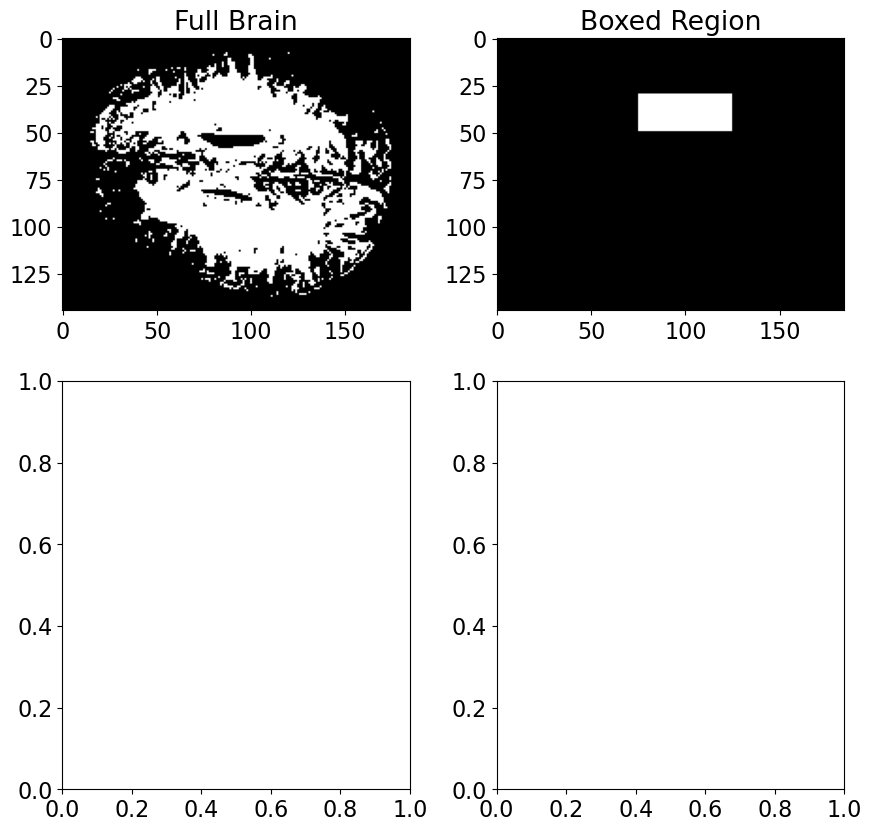

In [69]:
I_mask_factor = (gs_nonreg_estimates[:,:,0]!=0)

# moX_region = np.load('SavedMasks/monoX_const_SNR.npy')
# biX_region = np.invert(moX_region)
# biX_fullBrain = biX_region*I_mask_factor

boxed_region = np.zeros(gs_nonreg_estimates[:,:,0].shape)
boxed_region[30:50,75:125] = 1

fig, ax = plt.subplots(2,2,figsize=(9,9),tight_layout=True)
ax[0,0].imshow(I_mask_factor, cmap = 'gray', vmin=0, vmax = 1)
ax[0,0].set_title('Full Brain')
ax[0,1].imshow(boxed_region, cmap = 'gray', vmin=0, vmax = 1)
ax[0,1].set_title('Boxed Region')
# ax[1,0].imshow(moX_region, cmap = 'gray', vmin=0, vmax = 1)
# ax[1,0].set_title('Monoexponential')
# ax[1,1].imshow(biX_fullBrain, cmap = 'gray', vmin=0, vmax = 1)
# ax[1,1].set_title('Biexponential')

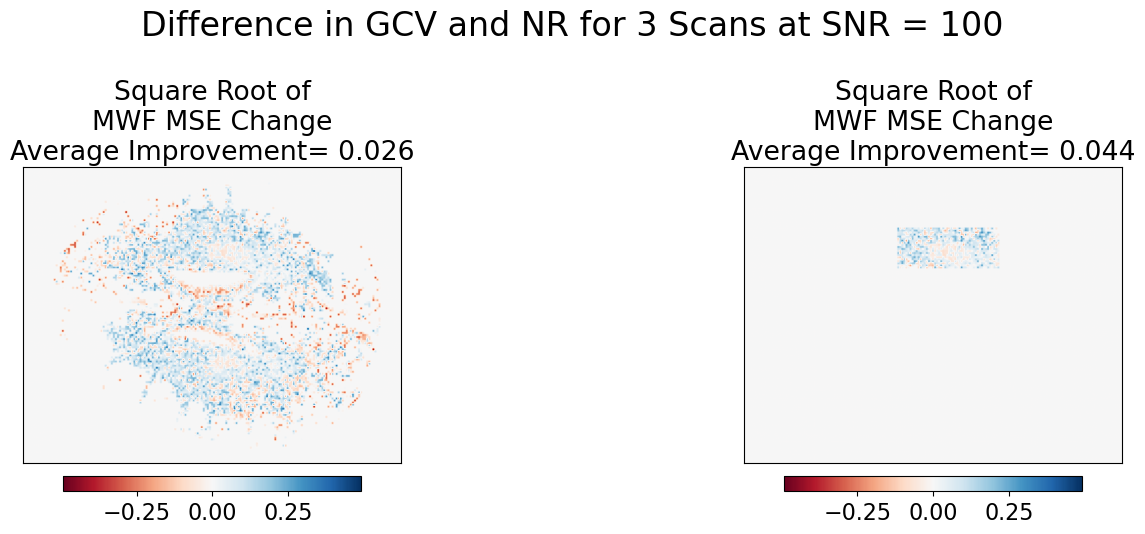

In [70]:

# MSE_biX = MSE_hold*biX_fullBrain
MSE_fullBrain = MSE_hold*I_mask_factor
MSE_box = MSE_hold*boxed_region

# MSE_biX_nonZ = MSE_biX[np.where(biX_fullBrain)]
MSE_fullBrain_nonZ = MSE_fullBrain[np.where(I_mask_factor)]
MSE_box_nonZ = MSE_box[np.where(boxed_region)]

fig, ax = plt.subplots(1,2,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Difference in GCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[0].imshow(MSE_fullBrain, cmap = or_map, vmin=-MSERange, vmax = MSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title("Square Root of\n" + 'MWF MSE Change' + f'\nAverage Improvement= {np.mean(MSE_fullBrain_nonZ):0.3f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[1].imshow(MSE_box, cmap = or_map, vmin=-MSERange, vmax = MSERange)
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
ax[1].set_title("Square Root of\n" + 'MWF MSE Change' + f'\nAverage Improvement= {np.mean(MSE_box_nonZ):0.3f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

# ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
# pNLLS = ax[2].imshow(MSE_biX, cmap = or_map, vmin=-MSERange, vmax = MSERange)
# fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04)
# ax[2].set_title("Square Root of\n" + 'MWF MSE Change' + f'\nAverage Improvement= {np.mean(MSE_biX_nonZ):0.3f}')
# ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

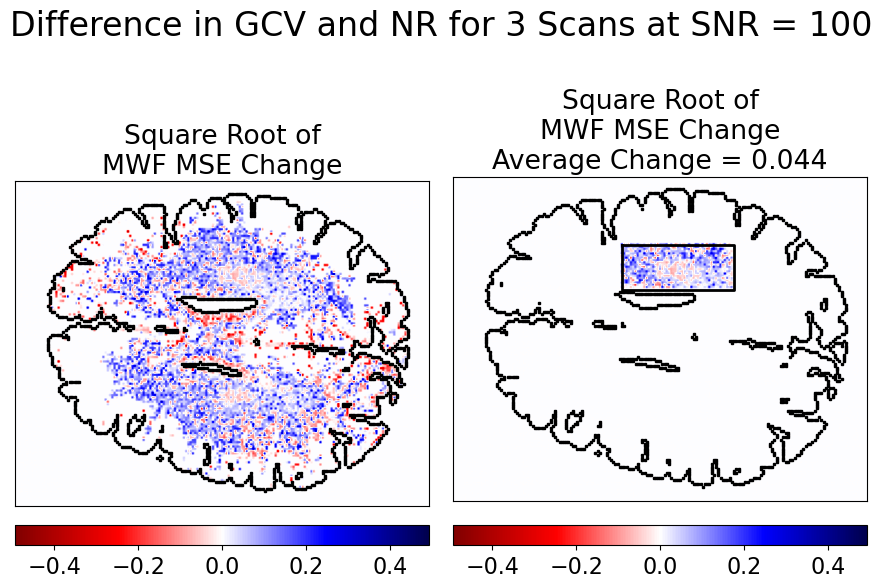

In [140]:

MSE_fullBrain = MSE_hold*I_mask_factor
MSE_box = MSE_hold*boxed_region

MSE_fullBrain_nonZ = MSE_fullBrain[np.where(I_mask_factor)]
MSE_box_nonZ = MSE_box[np.where(boxed_region)]


fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Difference in GCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[0].imshow(MSE_fullBrain, cmap = 'seismic_r', vmin=-MSERange, vmax = MSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title("\nSquare Root of\n" + 'MWF MSE Change')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[1].imshow(MSE_box, cmap = 'seismic_r', vmin=-MSERange, vmax = MSERange)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title("Square Root of\n" + 'MWF MSE Change' + f'\nAverage Change = {np.mean(MSE_box_nonZ):0.3f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# fig.colorbar(t22_im_error, ax = t22_error_plot, location = "bottom",  pad = 0.05)


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.26, 0.05, 0.55])
# fig.colorbar(pNLLS, cax=cbar_ax)
# fig.text(1, 0.82,"New Method\nSuperior")
# fig.text(1, 0.12,"Conventional\nMethod\nSuperior")

plt.show()

-2917.360341836247
3455.1182874971173


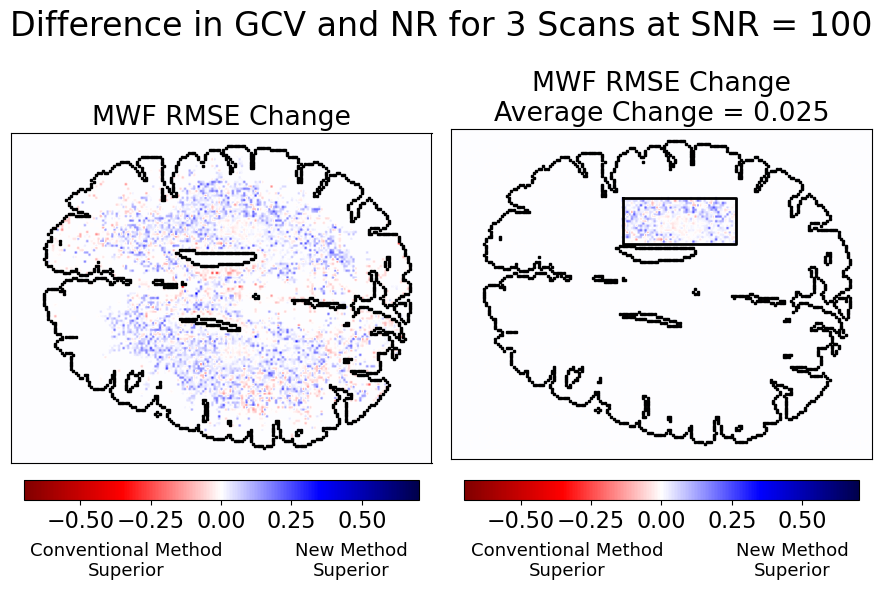

In [141]:


MSE_fullBrain = RMSE_improvement_diff[:,:,0]*I_mask_factor
MSE_box = RMSE_improvement_diff[:,:,0]*boxed_region

MSE_fullBrain_nonZ = MSE_fullBrain[np.where(I_mask_factor)]
MSE_box_nonZ = MSE_box[np.where(boxed_region)]

print(np.min(MSE_improvement_diff))
print(np.max(MSE_improvement_diff))
RMSERange = MSERange**(1/2)#np.max(np.abs(np.array([np.min(RMSE_improvement_diff), np.max(RMSE_improvement_diff)])))

fig, ax = plt.subplots(1,2,figsize=(9,5.5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Difference in GCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(MSE_fullBrain, cmap = 'seismic_r', vmin=-RMSERange, vmax = RMSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF RMSE Change')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(MSE_box, cmap = 'seismic_r', vmin=-RMSERange, vmax = RMSERange)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF RMSE Change' + f'\nAverage Change = {np.mean(MSE_box_nonZ):0.3f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# fig.colorbar(t22_im_error, ax = t22_error_plot, location = "bottom",  pad = 0.05)


plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')

plt.show()

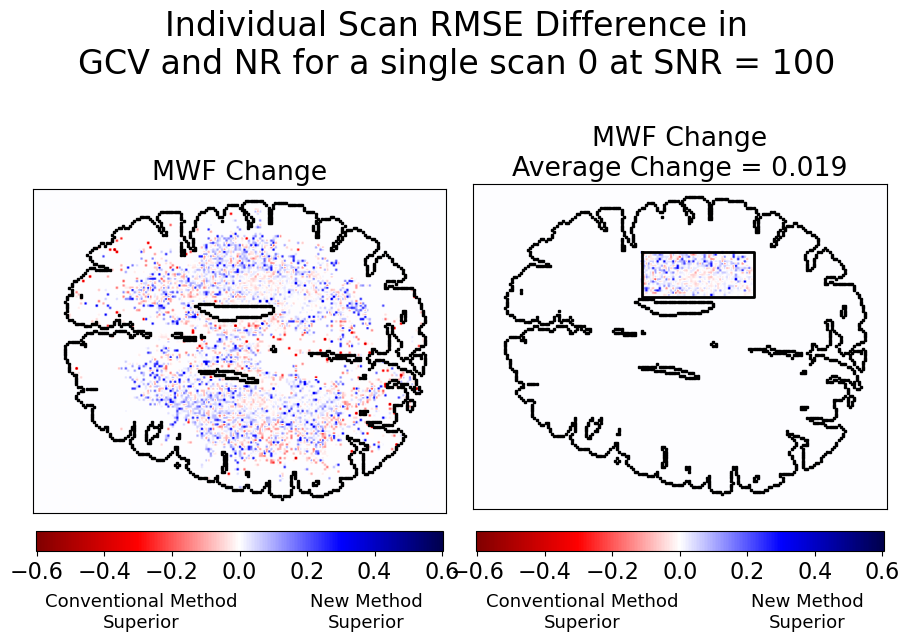

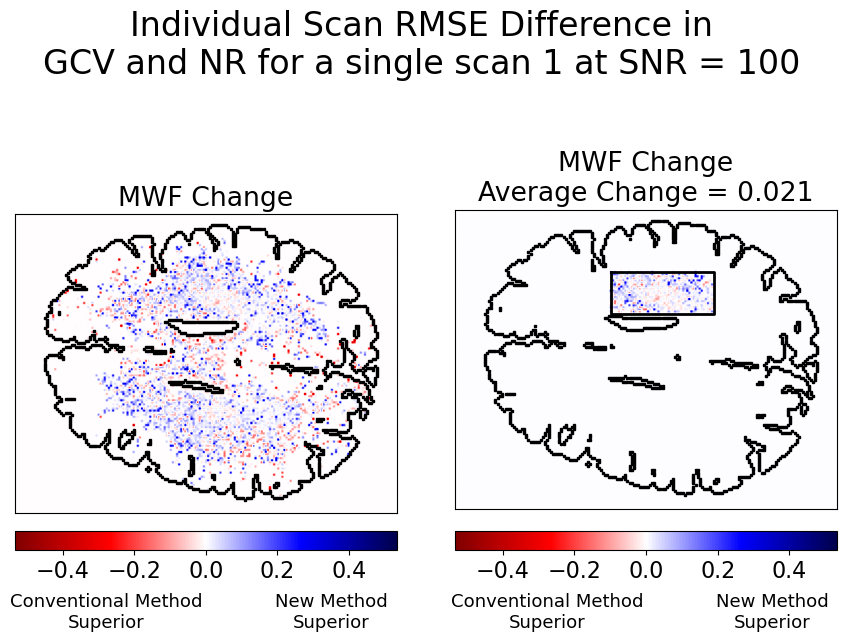

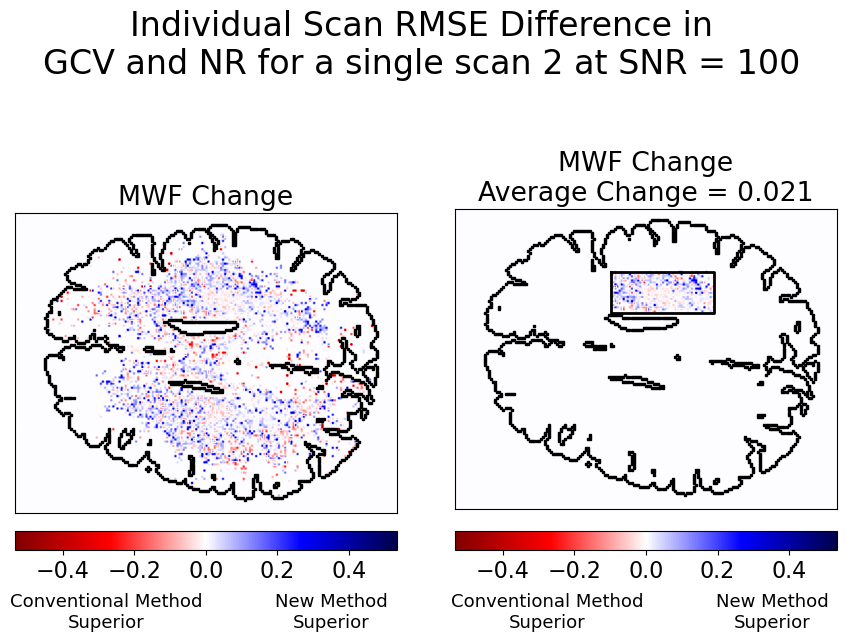

Mean Average Change for Single Scans = 0.020390521646077117


In [149]:
scan_num_list = np.arange(0,n_iter_input,1)

RMSE_sing_hold = []

for scan_num in scan_num_list:

    new_diff = np.abs(GCV_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])
    old_diff = np.abs(nonreg_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(np.array([np.min(absolute_comparative_diff), np.max(absolute_comparative_diff)])))
    # absolute_comparative_diff[absolute_comparative_diff == 0] = np.nan

    ACD_fullBrain = absolute_comparative_diff*I_mask_factor
    ACD_box = absolute_comparative_diff*boxed_region

    ACD_fullBrain_nonZ = ACD_fullBrain[np.where(I_mask_factor)]
    ACD_box_nonZ = ACD_box[np.where(boxed_region)]


    fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
    plt.rc('font', size  = 20)
    fig.suptitle(f'Individual Scan RMSE Difference in\nGCV and NR for a single scan {scan_num} at SNR = {SNR_goal}' )
    plt.rc('font', size  = 16)


    pNLLS = ax[0].imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
    ax[0].set_title('MWF Change')
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


    pNLLS = ax[1].imshow(ACD_box, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
    ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
    ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(ACD_box_nonZ):0.3f}')
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

    RMSE_sing_hold.append(np.mean(ACD_box_nonZ))


    plt.rc('font', size  = 13)
    fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
    fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
    fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
    fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')


    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([1, 0.26, 0.05, 0.55])
    # fig.colorbar(pNLLS, cax=cbar_ax)
    # fig.text(1, 0.82,"New Method\nSuperior")
    # fig.text(1, 0.12,"Conventional\nMethod\nSuperior")

    plt.show()

print(f'Mean Average Change for Single Scans = {np.mean(RMSE_sing_hold)}')

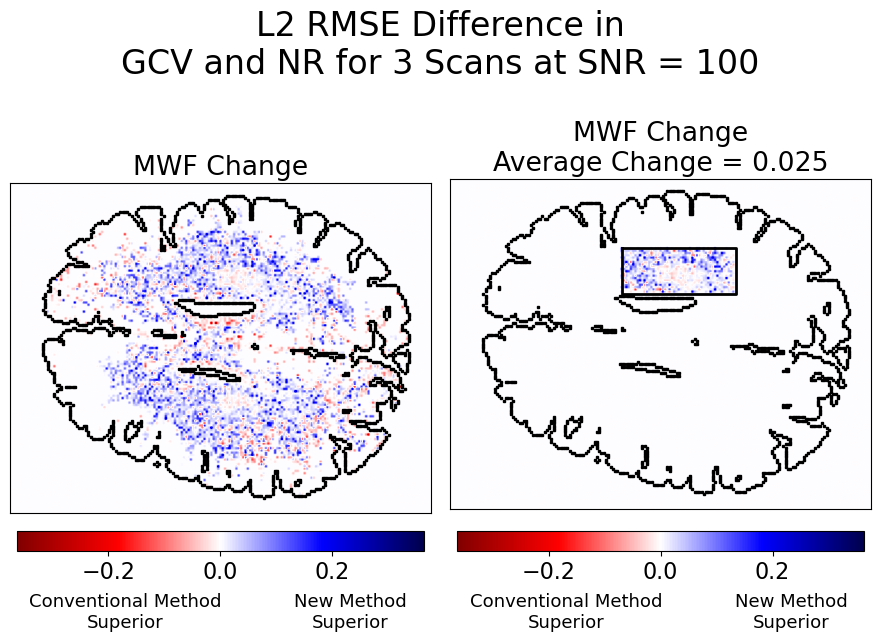

In [147]:
new_diff = (1/n_iter_input*np.sum((GCV_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)
old_diff = (1/n_iter_input*np.sum((nonreg_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)

#Abbreviated as ACD
absolute_comparative_diff = old_diff - new_diff
ACDRange = np.max(np.abs(np.array([np.min(absolute_comparative_diff), np.max(absolute_comparative_diff)])))
# absolute_comparative_diff[absolute_comparative_diff == 0] = np.nan


ACD_fullBrain = absolute_comparative_diff*I_mask_factor
ACD_box = absolute_comparative_diff*boxed_region

ACD_fullBrain_nonZ = ACD_fullBrain[np.where(I_mask_factor)]
ACD_box_nonZ = ACD_box[np.where(boxed_region)]


fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'L2 RMSE Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)


pNLLS = ax[0].imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF Change')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)



pNLLS = ax[1].imshow(ACD_box, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(ACD_box_nonZ):0.3f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.26, 0.05, 0.55])
# fig.colorbar(pNLLS, cax=cbar_ax)
# fig.text(1, 0.82,"New Method\nSuperior")
# fig.text(1, 0.12,"Conventional\nMethod\nSuperior")

plt.show()

In [75]:
RMSE_diff_L2_hold = []
RMSE_old_L2_hold = []
RMSE_new_L2_hold = []

for iter in range(n_iter_input):

    n_NR = iter + 1

    new_diff = (1/n_NR*np.sum((GCV_estimates[:n_NR,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)
    old_diff = (1/n_NR*np.sum((nonreg_estimates[:n_NR,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff

    ACD_box = absolute_comparative_diff*boxed_region
    ND_box = new_diff*boxed_region
    OD_box = old_diff*boxed_region

    ACD_box_nonZ = ACD_box[np.where(boxed_region)]
    ND_box_nonZ = ND_box[np.where(boxed_region)]
    OD_box_nonZ = OD_box[np.where(boxed_region)]

    RMSE_diff_L2_hold.append(np.mean(ACD_box_nonZ))
    RMSE_old_L2_hold.append(np.mean(OD_box_nonZ))
    RMSE_new_L2_hold.append(np.mean(ND_box_nonZ))

print("Diff")
print(RMSE_diff_L2_hold)
print("Old")
print(RMSE_old_L2_hold)
print("New")
print(RMSE_new_L2_hold)

Diff
[0.01855439380729132, 0.023194588303842686, 0.024879688907897535]
Old
[0.10961347864138077, 0.12542040570559548, 0.13112067782354536]
New
[0.09105908483408942, 0.1022258174017528, 0.10624098891564782]


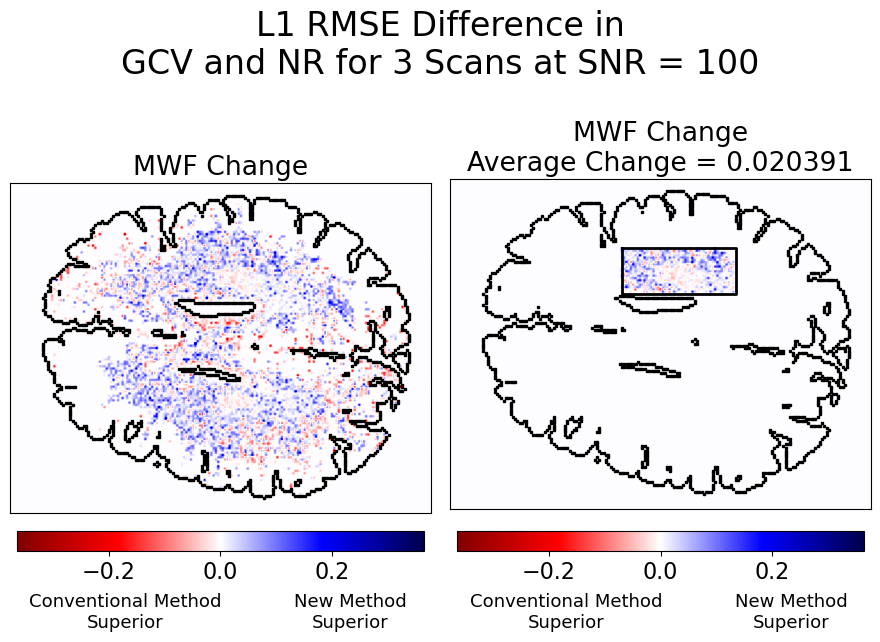

In [148]:
# new_diff = (1/n_iter_input*np.sum((all_GCV_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)
# old_diff = (1/n_iter_input*np.sum((all_nonreg_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)

new_diff = (1/n_iter_input*np.sum(np.abs((GCV_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])), axis = 0))
old_diff = (1/n_iter_input*np.sum(np.abs((nonreg_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])), axis = 0))

#Abbreviated as ACD
absolute_comparative_diff = old_diff - new_diff
ACDRange = np.max(np.abs(np.array([np.min(absolute_comparative_diff), np.max(absolute_comparative_diff)])))
# absolute_comparative_diff[absolute_comparative_diff == 0] = np.nan

# Zeroing all regions in the brain that aren't in the region of interest

ACD_fullBrain = absolute_comparative_diff*I_mask_factor
ACD_box = absolute_comparative_diff*boxed_region

# Making sure that only the region of interest is averaged

ACD_fullBrain_nonZ = ACD_fullBrain[np.where(I_mask_factor)]
ACD_box_nonZ = ACD_box[np.where(boxed_region)]


fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'L1 RMSE Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF Change')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


pNLLS = ax[1].imshow(ACD_box, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(ACD_box_nonZ):0.6f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([1, 0.26, 0.05, 0.55])
# fig.colorbar(pNLLS, cax=cbar_ax)
# fig.text(1, 0.82,"New Method\nSuperior")
# fig.text(1, 0.12,"Conventional\nMethod\nSuperior")

plt.show()

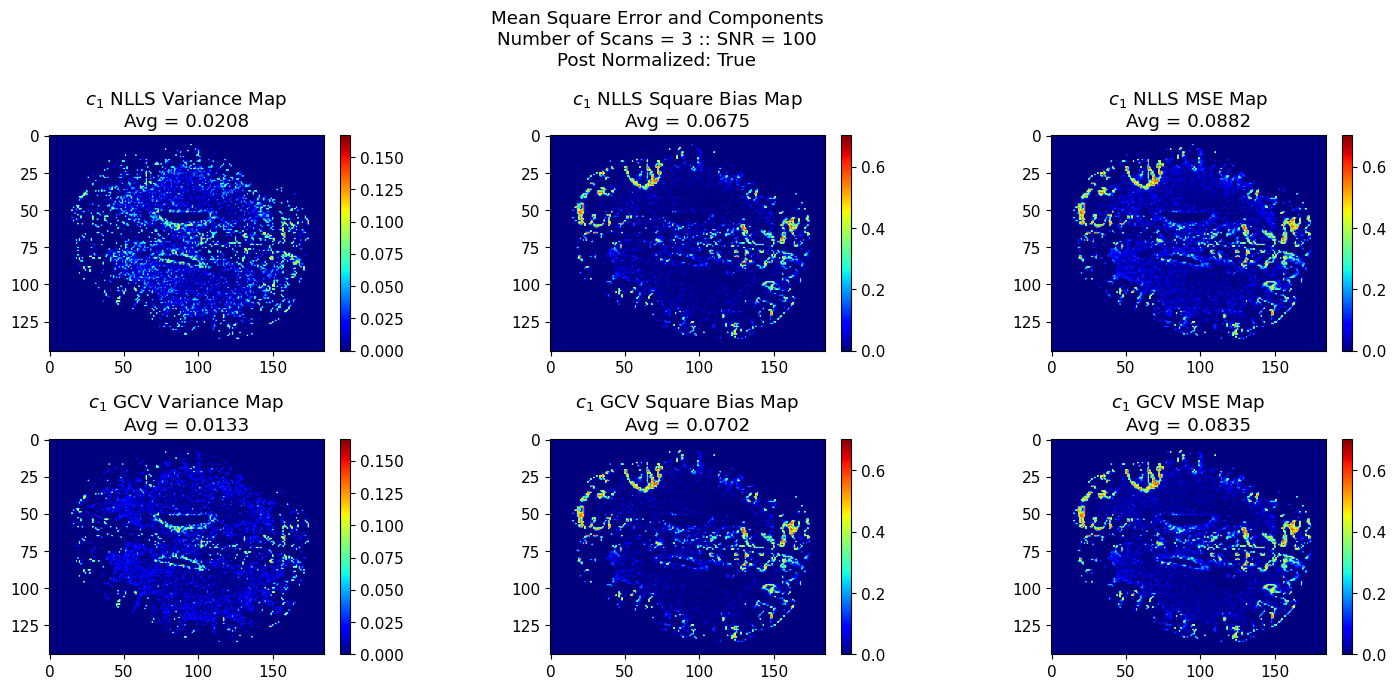

In [77]:
### MSE Component Maps - Full Brain
for param_oi in params_oi:

    plt.rc('font', size  = 11)
    fig, ax = plt.subplots(2,3,figsize=(15,7),tight_layout=True)
    fig.suptitle('Mean Square Error and Components' + f'\nNumber of Scans = {n_iter_input} :: SNR = {SNR_goal}\nPost Normalized: {post_normalize_data}' )

    pNLLS = ax[0,0].imshow(varMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,0], fraction=0.046, pad=0.04)
    ax[0,0].set_title(param_name_list[param_oi] + ' NLLS Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,0].imshow(varMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,0], fraction=0.046, pad=0.04)
    ax[1,0].set_title(param_name_list[param_oi] + ' GCV Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    pNLLS = ax[0,1].imshow(sqbMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,1], fraction=0.046, pad=0.04)
    ax[0,1].set_title(param_name_list[param_oi] + ' NLLS Square Bias Map' + '\nAvg = ' + str(round(np.mean(sqbMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,1].imshow(sqbMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,1], fraction=0.046, pad=0.04)
    ax[1,1].set_title(param_name_list[param_oi] + ' GCV Square Bias Map' + '\nAvg = ' + str(round(np.mean(sqbMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    pNLLS = ax[0,2].imshow(MSEMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,2], fraction=0.046, pad=0.04)
    ax[0,2].set_title(param_name_list[param_oi] + ' NLLS MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,2].imshow(MSEMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,2], fraction=0.046, pad=0.04)
    ax[1,2].set_title(param_name_list[param_oi] + ' GCV MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    plt.show()

In [78]:
# ### MSE Component Maps - Subsection (Noise Region)

# v1,v2,h1,h2 = noiseRegion #use this same region as the region to check out improvement in the white matter

# for param_oi in params_oi:

#     plt.rc('font', size  = 11)
#     fig, ax = plt.subplots(2,3,figsize=(15,7),tight_layout=True)
#     fig.suptitle('Mean Square Error and Components - Subregion Focus' + f'\nNumber of Scans = {n_iterations} :: SNR = {SNR_goal}\nPost Normalized: {post_normalize_data}' )

#     pNLLS = ax[0,0].imshow(varMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pNLLS,ax=ax[0,0], fraction=0.046, pad=0.04)
#     ax[0,0].set_title(param_name_list[param_oi] + ' NLLS Variance Map' + '\nRegion Avg = ' + str(round(np.mean(varMap_NLLS[v1:v2,h1:h2,param_oi]),4)))
#     ax[0,0].plot(hBox, vBox, color = 'white')

#     pGCV = ax[1,0].imshow(varMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pGCV,ax=ax[1,0], fraction=0.046, pad=0.04)
#     ax[1,0].set_title(param_name_list[param_oi] + ' GCV Variance Map' + '\nRegion Avg = ' + str(round(np.mean(varMap_GCV[v1:v2,h1:h2,param_oi]),4)))
#     ax[1,0].plot(hBox, vBox, color = 'white')

#     pNLLS = ax[0,1].imshow(sqbMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pNLLS,ax=ax[0,1], fraction=0.046, pad=0.04)
#     ax[0,1].set_title(param_name_list[param_oi] + ' NLLS Square Bias Map' + '\nRegion Avg = ' + str(round(np.mean(sqbMap_NLLS[v1:v2,h1:h2,param_oi]),4)))
#     ax[0,1].plot(hBox, vBox, color = 'white')

#     pGCV = ax[1,1].imshow(sqbMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pGCV,ax=ax[1,1], fraction=0.046, pad=0.04)
#     ax[1,1].set_title(param_name_list[param_oi] + ' GCV Square Bias Map' + '\nRegion Avg = ' + str(round(np.mean(sqbMap_GCV[v1:v2,h1:h2,param_oi]),4)))
#     ax[1,1].plot(hBox, vBox, color = 'white')

#     pNLLS = ax[0,2].imshow(MSEMap_NLLS[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pNLLS,ax=ax[0,2], fraction=0.046, pad=0.04)
#     ax[0,2].set_title(param_name_list[param_oi] + ' NLLS MSE Map' + '\nRegion Avg = ' + str(round(np.mean(MSEMap_NLLS[v1:v2,h1:h2,param_oi]),4)))
#     ax[0,2].plot(hBox, vBox, color = 'white')

#     pGCV = ax[1,2].imshow(MSEMap_GCV[:,:,param_oi], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
#     fig.colorbar(pGCV,ax=ax[1,2], fraction=0.046, pad=0.04)
#     ax[1,2].set_title(param_name_list[param_oi] + ' GCV MSE Map' + '\nRegion Avg = ' + str(round(np.mean(MSEMap_GCV[v1:v2,h1:h2,param_oi]),4)))
#     ax[1,2].plot(hBox, vBox, color = 'white')

#     plt.show()

### Bad Pixel Analysis

In [79]:
bp_vert = 70
bp_hori = 108

bp_GCV_estimates = GCV_estimates[:, bp_vert, bp_hori, :]
bp_GCV_lambdas = GCV_lambdas[:, bp_vert, bp_hori]
bp_nonreg_estimates = nonreg_estimates[:, bp_vert, bp_hori, :]
bp_gs_nonreg_estimates = gs_nonreg_estimates[bp_vert, bp_hori, :]

Text(0.2, -0.05, 'Conventional Method\nSuperior')

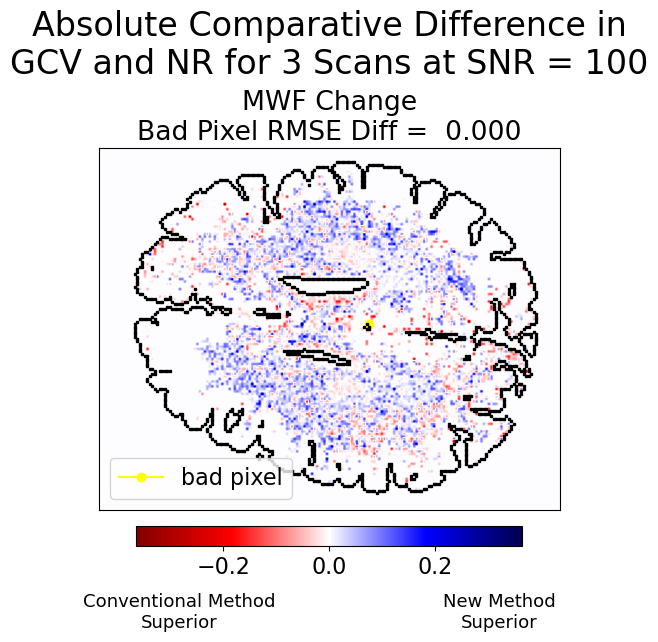

In [145]:
fig, ax = plt.subplots(1,1,figsize=(5,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Absolute Comparative Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

ax.imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax.imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
ax.plot(bp_hori,bp_vert, marker = 'o', color = 'yellow', label = 'bad pixel')
cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
ax.set_title(f'MWF Change\nBad Pixel RMSE Diff = {absolute_comparative_diff[bp_vert, bp_hori]: 0.3f}')
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
ax.legend()


plt.rc('font', size  = 13)
fig.text(0.84, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
# fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.2, -0.05,"Conventional Method\nSuperior", ha='center')

In [81]:
# print(f"Listing out all GCV lambdas associated with bad pixel:\n{bp_GCV_lambdas}")

for i in range(n_iter_input):

    print(f"Nonreg Param Est of iter {i+1}:\n{bp_nonreg_estimates[i,0]:0.2f}, {bp_nonreg_estimates[i,1]:0.2f}, {bp_nonreg_estimates[i,2]:0.2f}, {bp_nonreg_estimates[i,3]:0.2f}, {bp_nonreg_estimates[i,4]:0.2f}")

# print(f"Listing out all nonreg parameters associated with bad pixel:\n{bp_GCV_estimates}")

Nonreg Param Est of iter 1:
0.00, 1.00, 0.00, 83.75, 0.23
Nonreg Param Est of iter 2:
0.00, 1.00, 0.00, 86.77, 0.23
Nonreg Param Est of iter 3:
0.00, 1.00, 0.00, 84.22, 0.24


In [82]:
array_oi = np.var(bp_nonreg_estimates, axis = 0)

print(f"Nonreg Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

array_oi = np.var(bp_GCV_estimates, axis = 0)

print(f"Nonreg Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

Nonreg Param var:
0.00, 0.00, 0.00, 1.76, 0.00
Nonreg Param var:
0.00, 0.00, 0.00, 1.76, 0.00
